# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
DATA_STORE = Path('..', 'data', 'stock_prices.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    pass
mydf = pd.read_hdf(DATA_STORE)
mydf    

open       high        low      close     volume
ticker date                                                             
A      2000-01-03  53.726454  53.856080  45.969377  49.121329  3343600.0
       2000-01-04  46.481058  46.992738  44.175084  45.369006  3408500.0
       2000-01-05  45.198445  45.239380  41.828176  41.998737  4119200.0
       2000-01-06  42.046493  42.298923  39.658651  40.934441  1812900.0
       2000-01-07  40.293135  44.986951  40.252200  44.345645  2016900.0
...                      ...        ...        ...        ...        ...
ZUMZ   2018-03-21  23.800000  24.600000  23.605800  23.950000   354092.0
       2018-03-22  23.900000  24.350000  23.300000  23.350000   269607.0
       2018-03-23  23.550000  24.200000  23.450000  23.550000   301584.0
       2018-03-26  23.750000  24.800000  23.700000  24.650000   375320.0
       2018-03-27  24.650000  24.650000  23.350000  23.600000   403884.0

[11343366 rows x 5 columns]

## Select 500 most-traded stocks prior to 2017

In [6]:
#remove data for 2017 onward
mydf = mydf[mydf.index.get_level_values(1) < '2017-01-01']
#remove data for < 2016-01-01
mydf = mydf[mydf.index.get_level_values(1) >= '2014-01-01']

mydf

open       high        low      close     volume
ticker date                                                             
A      2014-01-02  39.748059  39.748059  39.086752  39.128518  1916200.0
       2014-01-03  39.253819  39.918607  39.163324  39.622759  1866700.0
       2014-01-06  39.956893  40.165727  39.372158  39.427847  1777300.0
       2014-01-07  39.643642  40.116999  39.629720  39.991699  1463200.0
       2014-01-08  39.908165  40.750462  39.796787  40.646045  2659500.0
...                      ...        ...        ...        ...        ...
ZUMZ   2016-12-23  20.950000  21.500000  20.950000  21.350000   532292.0
       2016-12-27  21.200000  21.700000  21.200000  21.450000   308004.0
       2016-12-28  21.550000  21.749900  21.325000  21.450000   165827.0
       2016-12-29  21.550000  22.050000  21.400000  21.900000   322108.0
       2016-12-30  21.900000  22.190000  21.600000  21.850000   295429.0

[2225147 rows x 5 columns]

In [7]:
#Compute the dollar volume for each day
mydf['daydv'] = mydf['close'] * mydf['volume']
mydf

open       high        low      close     volume  \
ticker date                                                                
A      2014-01-02  39.748059  39.748059  39.086752  39.128518  1916200.0   
       2014-01-03  39.253819  39.918607  39.163324  39.622759  1866700.0   
       2014-01-06  39.956893  40.165727  39.372158  39.427847  1777300.0   
       2014-01-07  39.643642  40.116999  39.629720  39.991699  1463200.0   
       2014-01-08  39.908165  40.750462  39.796787  40.646045  2659500.0   
...                      ...        ...        ...        ...        ...   
ZUMZ   2016-12-23  20.950000  21.500000  20.950000  21.350000   532292.0   
       2016-12-27  21.200000  21.700000  21.200000  21.450000   308004.0   
       2016-12-28  21.550000  21.749900  21.325000  21.450000   165827.0   
       2016-12-29  21.550000  22.050000  21.400000  21.900000   322108.0   
       2016-12-30  21.900000  22.190000  21.600000  21.850000   295429.0   

                          daydv  
ticker date                      
A      2014-01-02  7.497807e+07  
       2014-01-03  7.396380e+07  
       2014-01-06  7.007511e+07  
       2014-01-07  5.851585e+07  
       2014-01-08  1.080982e+08  
...                         ...  
ZUMZ   2016-12-23  1.136443e+07  
       2016-12-27  6.606686e+06  
       2016-12-28  3.556989e+06  
       2016-12-29  7.054165e+06  
       2016-12-30  6.455124e+06  

[2225147 rows x 6 columns]

Compute the dollar volume as the product of the adjusted close price and the adjusted volume:

In [8]:


#For each name, add the dollar volumes
mydf = mydf
#mynamedv = mydf.groupby(mydf.index.get_level_values(0))['daydv'].sum()
mynamedv = mydf.groupby(level=0)['daydv'].sum()
#count the number of data points per name - we discard those with insufficient data
#mytradingdays = mydf.groupby(mydf.index.get_level_values(0))['daydv'].count()
mytradingdays = mydf.groupby(level=0)['daydv'].count()
mydf = pd.merge(mydf, mynamedv, on=['ticker'])
mydf = pd.merge(mydf, mytradingdays, on=['ticker'])
#The problem with this is that the series mynamedv and mytradingdays lose their date index
#I have tried everything I can think of; Pandas really doesn't want me to use a datetimeindex as a column.

In [9]:
mydf



,open,high,low,close,volume,daydv_x,daydv_y,daydv
ticker,,,,,,,,
A,39.748059,39.748059,39.086752,39.128518,1916200.0,7.497807e+07,6.978716e+10,756
A,39.253819,39.918607,39.163324,39.622759,1866700.0,7.396380e+07,6.978716e+10,756
A,39.956893,40.165727,39.372158,39.427847,1777300.0,7.007511e+07,6.978716e+10,756
A,39.643642,40.116999,39.629720,39.991699,1463200.0,5.851585e+07,6.978716e+10,756
A,39.908165,40.750462,39.796787,40.646045,2659500.0,1.080982e+08,6.978716e+10,756
...,...,...,...,...,...,...,...,...
ZUMZ,20.950000,21.500000,20.950000,21.350000,532292.0,1.136443e+07,7.164979e+09,756
ZUMZ,21.200000,21.700000,21.200000,21.450000,308004.0,6.606686e+06,7.164979e+09,756
ZUMZ,21.550000,21.749900,21.325000,21.450000,165827.0,3.556989e+06,7.164979e+09,756


In [10]:
#remove names with < 2 years of data
mydf = mydf[mydf['daydv'] > 500]
mydf

,open,high,low,close,volume,daydv_x,daydv_y,daydv
ticker,,,,,,,,
A,39.748059,39.748059,39.086752,39.128518,1916200.0,7.497807e+07,6.978716e+10,756
A,39.253819,39.918607,39.163324,39.622759,1866700.0,7.396380e+07,6.978716e+10,756
A,39.956893,40.165727,39.372158,39.427847,1777300.0,7.007511e+07,6.978716e+10,756
A,39.643642,40.116999,39.629720,39.991699,1463200.0,5.851585e+07,6.978716e+10,756
A,39.908165,40.750462,39.796787,40.646045,2659500.0,1.080982e+08,6.978716e+10,756
...,...,...,...,...,...,...,...,...
ZUMZ,20.950000,21.500000,20.950000,21.350000,532292.0,1.136443e+07,7.164979e+09,756
ZUMZ,21.200000,21.700000,21.200000,21.450000,308004.0,6.606686e+06,7.164979e+09,756
ZUMZ,21.550000,21.749900,21.325000,21.450000,165827.0,3.556989e+06,7.164979e+09,756


In [11]:
#compute average volume


mydf['avgvolume'] = mydf['daydv_y'] / mydf['daydv']
mydf

,open,high,low,close,volume,daydv_x,daydv_y,daydv,avgvolume
ticker,,,,,,,,,
A,39.748059,39.748059,39.086752,39.128518,1916200.0,7.497807e+07,6.978716e+10,756,9.231105e+07
A,39.253819,39.918607,39.163324,39.622759,1866700.0,7.396380e+07,6.978716e+10,756,9.231105e+07
A,39.956893,40.165727,39.372158,39.427847,1777300.0,7.007511e+07,6.978716e+10,756,9.231105e+07
A,39.643642,40.116999,39.629720,39.991699,1463200.0,5.851585e+07,6.978716e+10,756,9.231105e+07
A,39.908165,40.750462,39.796787,40.646045,2659500.0,1.080982e+08,6.978716e+10,756,9.231105e+07
...,...,...,...,...,...,...,...,...,...
ZUMZ,20.950000,21.500000,20.950000,21.350000,532292.0,1.136443e+07,7.164979e+09,756,9.477486e+06
ZUMZ,21.200000,21.700000,21.200000,21.450000,308004.0,6.606686e+06,7.164979e+09,756,9.477486e+06
ZUMZ,21.550000,21.749900,21.325000,21.450000,165827.0,3.556989e+06,7.164979e+09,756,9.477486e+06


In [12]:
#add a shift column and compute daily returns
mydf['close'].shift(1)
mydf['dailyreturn'] = (mydf['close'] - mydf['close'].shift(1))/mydf['close']
mydf

,open,high,low,close,volume,daydv_x,daydv_y,daydv,avgvolume,dailyreturn
ticker,,,,,,,,,,
A,39.748059,39.748059,39.086752,39.128518,1916200.0,7.497807e+07,6.978716e+10,756,9.231105e+07,NaN
A,39.253819,39.918607,39.163324,39.622759,1866700.0,7.396380e+07,6.978716e+10,756,9.231105e+07,0.012474
A,39.956893,40.165727,39.372158,39.427847,1777300.0,7.007511e+07,6.978716e+10,756,9.231105e+07,-0.004944
A,39.643642,40.116999,39.629720,39.991699,1463200.0,5.851585e+07,6.978716e+10,756,9.231105e+07,0.014099
A,39.908165,40.750462,39.796787,40.646045,2659500.0,1.080982e+08,6.978716e+10,756,9.231105e+07,0.016099
...,...,...,...,...,...,...,...,...,...,...
ZUMZ,20.950000,21.500000,20.950000,21.350000,532292.0,1.136443e+07,7.164979e+09,756,9.477486e+06,0.016393
ZUMZ,21.200000,21.700000,21.200000,21.450000,308004.0,6.606686e+06,7.164979e+09,756,9.477486e+06,0.004662
ZUMZ,21.550000,21.749900,21.325000,21.450000,165827.0,3.556989e+06,7.164979e+09,756,9.477486e+06,0.000000


In [13]:
#sort the data so we can get the 500 most important names by average volumne
#don't sort mydf, because we want to look at its data in order.
#mydf1 = mydf
mydf1 = mydf.sort_values('avgvolume', ascending=False)
mydf1

,open,high,low,close,volume,daydv_x,daydv_y,daydv,avgvolume,dailyreturn
ticker,,,,,,,,,,
AAPL,111.715852,112.344683,111.155799,111.902536,28779313.0,3.220478e+09,3.819720e+12,756,5.052539e+09,0.007376
AAPL,95.149511,95.244102,93.361733,93.815772,51491286.0,4.830695e+09,3.819720e+12,756,5.052539e+09,-0.015830
AAPL,94.960328,95.083297,93.238764,93.409029,63688562.0,5.949087e+09,3.819720e+12,756,5.052539e+09,-0.010734
AAPL,95.849487,96.275149,94.411698,94.411698,53583368.0,5.058897e+09,3.819720e+12,756,5.052539e+09,-0.009218
AAPL,95.244102,96.511627,94.875196,95.281939,66331592.0,6.320203e+09,3.819720e+12,756,5.052539e+09,-0.002879
...,...,...,...,...,...,...,...,...,...,...
BBGI,4.552388,4.689139,4.552388,4.680016,1480.0,6.926424e+03,2.448993e+07,756,3.239408e+04,0.001949
BBGI,4.579665,4.652648,4.579665,4.643525,541.0,2.512147e+03,2.448993e+07,756,3.239408e+04,-0.007859
BBGI,4.607034,4.607034,4.561419,4.579665,1734.0,7.941139e+03,2.448993e+07,756,3.239408e+04,-0.013944


In [14]:
#Get the list of unique names
namelist = (mydf1.index.get_level_values(0)).drop_duplicates(keep='first')
print(namelist[0:500])

Index(['AAPL', 'FB', 'AMZN', 'MSFT', 'GOOGL', 'BAC', 'NFLX', 'GOOG', 'TSLA',
       'GILD',
       ...
       'HRB', 'THC', 'URBN', 'CMS', 'CA', 'APH', 'ARG', 'COO', 'WPX', 'XL'],
      dtype='object', name='ticker', length=500)


## Remove outliers based on daily returns

In [15]:
#We have a daily return column now for all of the transactions. We are removing any row that is out of range,
#because the theory is that it is an error.
#We should do this for both mydf (unsorted) and mydf1 (sorted)
mydf = mydf[(mydf['dailyreturn'] <= 1.0) & (mydf['dailyreturn'] >= -1.0)]
mydf1 = mydf1[(mydf1['dailyreturn'] <= 1.0) & (mydf1['dailyreturn'] >= -1.0)]
mydf

,open,high,low,close,volume,daydv_x,daydv_y,daydv,avgvolume,dailyreturn
ticker,,,,,,,,,,
A,39.253819,39.918607,39.163324,39.622759,1866700.0,7.396380e+07,6.978716e+10,756,9.231105e+07,0.012474
A,39.956893,40.165727,39.372158,39.427847,1777300.0,7.007511e+07,6.978716e+10,756,9.231105e+07,-0.004944
A,39.643642,40.116999,39.629720,39.991699,1463200.0,5.851585e+07,6.978716e+10,756,9.231105e+07,0.014099
A,39.908165,40.750462,39.796787,40.646045,2659500.0,1.080982e+08,6.978716e+10,756,9.231105e+07,0.016099
A,40.653006,40.847918,40.284066,40.659967,1757600.0,7.146396e+07,6.978716e+10,756,9.231105e+07,0.000342
...,...,...,...,...,...,...,...,...,...,...
ZUMZ,20.950000,21.500000,20.950000,21.350000,532292.0,1.136443e+07,7.164979e+09,756,9.477486e+06,0.016393
ZUMZ,21.200000,21.700000,21.200000,21.450000,308004.0,6.606686e+06,7.164979e+09,756,9.477486e+06,0.004662
ZUMZ,21.550000,21.749900,21.325000,21.450000,165827.0,3.556989e+06,7.164979e+09,756,9.477486e+06,0.000000


In [17]:
#I do not know if these metrics are to be generated for all 500 top stocks, or one time for the entire market, or
#something else. I normally see these metrics applied to an individual stock.

## Compute returns

0      0.012474
1     -0.004944
2      0.014099
3      0.016099
4      0.000342
         ...   
750    0.004978
751    0.006665
752   -0.017279
753    0.001136
754   -0.001756
Name: dailyreturn, Length: 755, dtype: float64


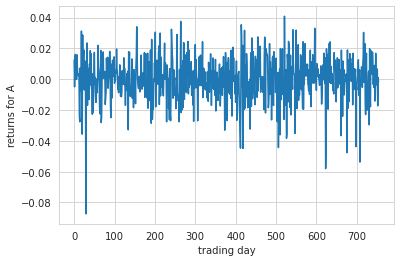

In [18]:
#create series that can be used in the various functions
return_A = mydf.loc['A']['dailyreturn'].reset_index()['dailyreturn']
open_A = mydf.loc['A']['open'].reset_index()['open']
high_A = mydf.loc['A']['high'].reset_index()['high']
low_A = mydf.loc['A']['low'].reset_index()['low']
close_A = mydf.loc['A']['close'].reset_index()['close']
volume_A = mydf.loc['A']['volume'].reset_index()['volume']
print(return_A)
#type(return_A)
#The returns were computed for each name and for its time series, earlier in this notebook.
#We will plot some of the returns
#return_A = mydf[mydf.loc('A')]['dailyreturn']
plt.xlabel('trading day')
plt.ylabel('returns for A')
plt.plot(return_A)
plt.show()

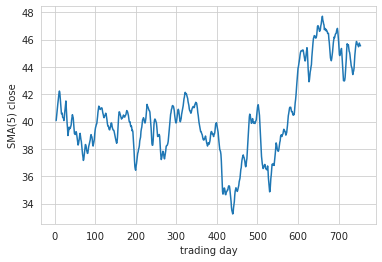

In [19]:
#Simple moving average (SMA) of close
#close_A = mydf7[mydf7['ticker'] == 'A']['close']
plt.xlabel('trading day')
plt.ylabel('SMA(5) close')
plt.plot(talib.SMA(close_A, timeperiod=5))

plt.show()

## Bollinger Bands

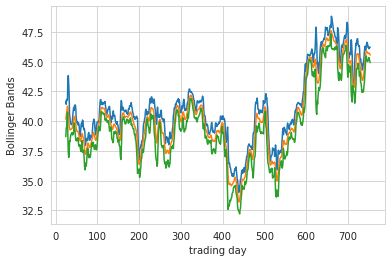

In [20]:
from talib.abstract import *
from talib import MA_Type
#upper, middle, lower = BBANDS(return_A, 20, 2, 2)
upper, middle, lower = BBANDS(close_A, matype=MA_Type.T3)
plt.xlabel('trading day')
plt.ylabel('Bollinger Bands')
plt.plot(upper)
plt.plot(middle)
plt.plot(lower)

plt.show()

## Momentum Indicators

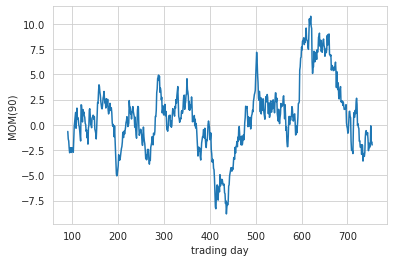

In [21]:
#Momentun (MOM)
#NCO
mom_output = talib.MOM(close_A, timeperiod=90)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('MOM(90)')
plt.plot(mom_output)


plt.show()

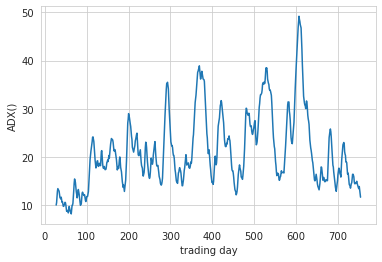

In [22]:
#Average Directional Movement Index (ADX)

adx_metric = talib.ADX(high_A, low_A, close_A)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('ADX()')
plt.plot(adx_metric)



plt.show()

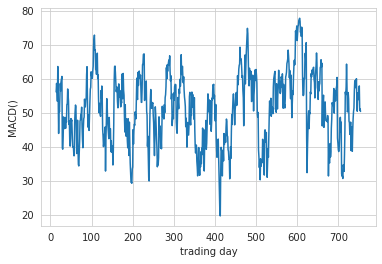

In [23]:
#Relative Strength Index (RSI)
rsi_A = RSI(close_A, timeperiod=14)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('MACD()')
plt.plot(rsi_A)
plt.show()

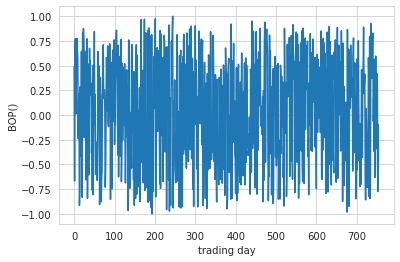

In [24]:
#Balance of Power (BOP)

bop_A = BOP(open_A, high_A, low_A, close_A)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('BOP()')
plt.plot(bop_A)
plt.show()


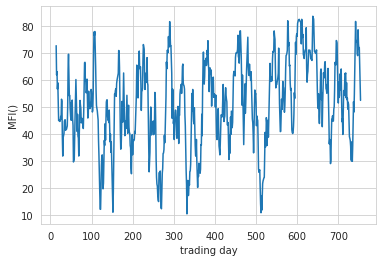

In [25]:
#money flow index (MFI)

mfi_A = MFI(high_A, low_A, close_A, volume_A, timeperiod=14)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('MFI()')
plt.plot(mfi_A)
plt.show()

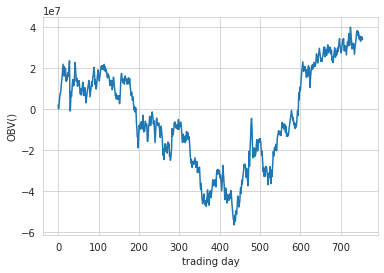

In [26]:
#On Balance Volume (OBV)

obv_A = OBV(close_A, volume_A)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('OBV()')
plt.plot(obv_A)
plt.show()

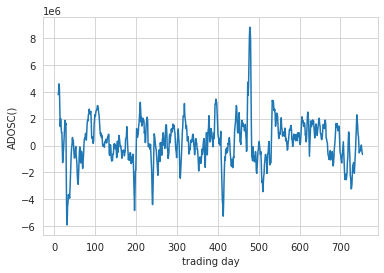

In [27]:
#Chaikin A/D Oscillator (ADOSC)

adosc_A = ADOSC(high_A, low_A, close_A, volume_A, fastperiod=3, slowperiod=10)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('ADOSC()')
plt.plot(adosc_A)
plt.show()

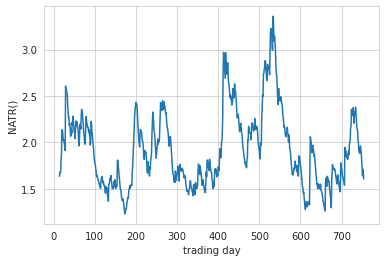

In [28]:
#ormalized Average True Range (NATR)

natr_A = NATR(high_A, low_A, close_A,  timeperiod=14)
from talib.abstract import *
from talib import MA_Type

plt.xlabel('trading day')
plt.ylabel('NATR()')
plt.plot(natr_A)
plt.show()

In [29]:
#French-Fama indicators
#I have read the documents on these indicators, but the model requires significant amounts
#of data that does not derive from the exercise; data from the Ken French data archive seems to be
#of a different timescale. I am not sure what is intended for this, whether I am overthinking and should
#just follow their examples.

#I obtained 10-year T-bill data from a different site, and converted it to a daily rate, to use
#for the risk free rate:

#RFDATA = Path('..', 'data', 'riskfreerate.csv')
rfdf = pd.read_csv('../data/riskfreerate.csv',
                parse_dates=['date'],
               index_col=['date'])
rfdf1 = (rfdf.iloc[1:2759]) #to get the trading days that line up with the rest of my data

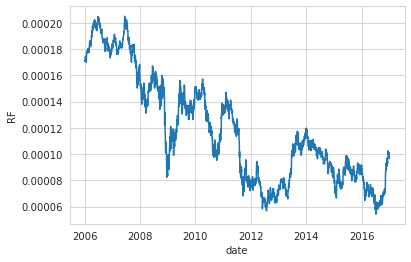

In [30]:
#I need to either do more reading, or peek at an answer, to go further.
plt.xlabel('date')
plt.ylabel('RF')
plt.plot(rfdf1['RF'])
plt.show()

TA-Lib offers the following choices - feel free to experiment with as many as you like (but you don't have to..):

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

## Rolling Factor Betas

## Persist results

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    pass